In [37]:
import sys

sys.path.append("..")
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from typing import Callable


In [15]:
# We define some helper functions...

# Euclidean Norm (square root of the sum of the squares of its components)
def euclidean_norm(x):
    return torch.norm(x, p=2, dim=-1)

# Gaussian Radial Basis Function
def rbf_gaussian(x):
    return (-x.pow(2)).exp()

def fun(x, y, center, shape):
    diff = center.T - [x, y]
    r = np.linalg.norm(diff, axis=0)
    return np.exp(-(shape * r) ** 2)

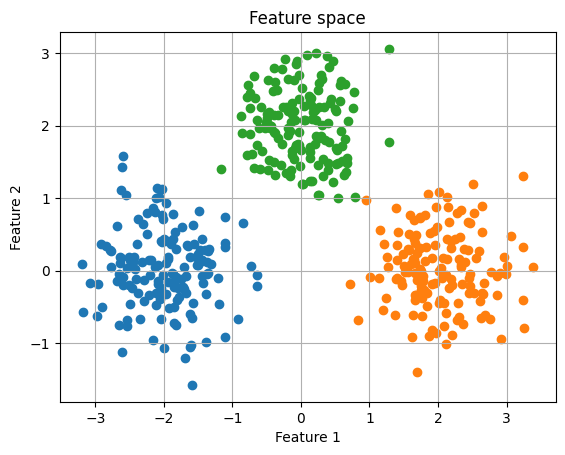

In [16]:
# First we generate a Random Dataset, simulating 3 clusters

N_training = 100
N_validation = 50
N = N_training + N_validation

X0 = np.array([-2, 0]).T + 0.5 * np.random.normal(size=(N, 2))
X1 = np.array([2, 0]).T + 0.5 * np.random.normal(size=(N, 2))
X2 = np.array([0, 2]).T + 0.5 * np.random.normal(size=(N, 2))
X = np.concatenate([X0, X1, X2])

labels = np.zeros((3 * N, 1))
labels[N:2 * N] = 1
labels[2 * N:] = 2

# Training dataset
indices = np.random.permutation(3 * N)
trn_indices, val_indices = indices[:N_training], indices[N_training:]
Tdataset = ([torch.tensor(X[trn_indices], dtype=torch.float32), torch.tensor(labels[trn_indices], dtype=torch.float32)])
Vdataset = ([torch.tensor(X[val_indices], dtype=torch.float32), torch.tensor(labels[val_indices], dtype=torch.float32)])

# Plot dataset
plt.scatter(X0[:, 0], X0[:, 1])
plt.scatter(X1[:, 0], X1[:, 1])
plt.scatter(X2[:, 0], X2[:, 1])
plt.grid()
plt.title('Feature space')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.plot()
plt.show()

In [17]:
# Idea: we need a specific RBF model --> We define a nn.Module

class RBFLayer(nn.Module):
    """
    Defines a Radial Basis Function Layer

    An RBF is defined by 5 elements:
        1. A radial kernel phi (kernel = region)
        2. A positive shape parameter epsilon
        3. The number of kernels N, and their relative
           centers c_i, i=1, ..., N
        4. A norm ||.||
        5. A set of weights w_i, i=1, ..., N

    The output of an RBF is given by
    y(x) = sum_{i=1}^N a_i * phi(eps_i * ||x - c_i||)

    For more information check [1,2]

    [1] https://en.wikipedia.org/wiki/Radial_basis_function
    [2] https://en.wikipedia.org/wiki/Radial_basis_function_network

    Parameters
    ----------
        in_features_dim: int
            Dimensionality of the input features
        num_kernels: int
            Number of kernels to use
        out_features_dim: int
            Dimensionality of the output features
        radial_function: Callable[[torch.Tensor], torch.Tensor]
            A radial basis function that returns a tensor of real values
            given a tensor of real values
        norm_function: Callable[[torch.Tensor], torch.Tensor]
            Normalization function applied on the features
        normalization: bool, optional
            if True applies the normalization trick to the rbf layer
        initial_shape_parameter: torch.Tensor, optional
            Sets the shape parameter to the desired value.
        initial_centers_parameter: torch.Tensor, optional
            Sets the centers to the desired value.
        initial_weights_parameters: torch.Tensor, optional
            Sets the weights parameter to the desired value.
        constant_shape_parameter: bool, optional
            Sets the shapes parameters to a non-learnable constant.
            initial_shape_parameter must be different than None if
            constant_shape_parameter is True
        constant_centers_parameter: bool, optional
            Sets the centers to a non-learnable constant.
            initial_centers_parameter must be different than None if
            constant_centers_parameter is True
        constant_weights_parameters: bool, optional
            Sets the weights to a non-learnable constant.
            initial_weights_parameters must be different than None if
            constant_weights_parameters is True
    """

    def __init__(self,
                 in_features_dim: int,
                 num_kernels: int,
                 out_features_dim: int,
                 radial_function: Callable[[torch.Tensor], torch.Tensor],
                 norm_function: Callable[[torch.Tensor], torch.Tensor],
                 normalization: bool = True,
                 initial_shape_parameter: torch.Tensor = None,
                 initial_centers_parameter: torch.Tensor = None,
                 initial_weights_parameters: torch.Tensor = None,
                 constant_shape_parameter: bool = False,
                 constant_centers_parameter: bool = False,
                 constant_weights_parameters: bool = False):
        super(RBFLayer, self).__init__()

        self.in_features_dim = in_features_dim
        self.num_kernels = num_kernels
        self.out_features_dim = out_features_dim
        self.radial_function = radial_function
        self.norm_function = norm_function
        self.normalization = normalization

        self.initial_shape_parameter = initial_shape_parameter
        self.constant_shape_parameter = constant_shape_parameter

        self.initial_centers_parameter = initial_centers_parameter
        self.constant_centers_parameter = constant_centers_parameter

        self.initial_weights_parameters = initial_weights_parameters
        self.constant_weights_parameters = constant_weights_parameters

        assert radial_function is not None  \
            and norm_function is not None
        assert normalization is False or normalization is True

        self._make_parameters()

    def _make_parameters(self) -> None:
        # Initialize linear combination weights
        if self.constant_weights_parameters:
            self.weights = nn.Parameter(
                self.initial_weights_parameters, requires_grad=False)
        else:
            self.weights = nn.Parameter(
                torch.zeros(
                    self.out_features_dim,
                    self.num_kernels,
                    dtype=torch.float32))

        # Initialize kernels' centers
        if self.constant_centers_parameter:
            self.kernels_centers = nn.Parameter(
                self.initial_centers_parameter, requires_grad=False)
        else:
            self.kernels_centers = nn.Parameter(
                torch.zeros(
                    self.num_kernels,
                    self.in_features_dim,
                    dtype=torch.float32))

        # Initialize shape parameter
        if self.constant_shape_parameter:
            self.log_shapes = nn.Parameter(
                self.initial_shape_parameter, requires_grad=False)
        else:
            self.log_shapes = nn.Parameter(
                torch.zeros(self.num_kernels, dtype=torch.float32))

        self.reset()

    def reset(self,
              upper_bound_kernels: float = 1.0,
              std_shapes: float = 0.1,
              gain_weights: float = 1.0) -> None:
        """
        Resets all the parameters.

        Parameters
        ----------
            upper_bound_kernels: float, optional
                Randomly samples the centers of the kernels from a uniform
                distribution U(-x, x) where x = upper_bound_kernels
            std_shapes: float, optional
                Randomly samples the shape parameters from a normal
                distribution with mean 0 and std_shapes
            gain_weights: float, optional
                Randomly samples the weights used to linearly combine the
                output of the kernels from a xavier_uniform with gain
                equal to gain_weights
        """
        if self.initial_centers_parameter is None:
            nn.init.uniform_(
                self.kernels_centers,
                a=-upper_bound_kernels,
                b=upper_bound_kernels)

        if self.initial_shape_parameter is None:
            nn.init.normal_(self.log_shapes, mean=0.0, std=std_shapes)

        if self.initial_weights_parameters is None:
            nn.init.xavier_uniform_(self.weights, gain=gain_weights)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        """
        Computes the ouput of the RBF layer given an input vector

        Parameters
        ----------
            input: torch.Tensor
                Input tensor of size B x Fin, where B is the batch size,
                and Fin is the feature space dimensionality of the input

        Returns
        ----------
            out: torch.Tensor
                Output tensor of size B x Fout, where B is the batch
                size of the input, and Fout is the output feature space
                dimensionality
        """

        # Input has size B x Fin
        batch_size = input.size(0)

        # Compute difference from centers
        # c has size B x num_kernels x Fin
        c = self.kernels_centers.expand(batch_size, self.num_kernels,
                                        self.in_features_dim)

        diff = input.view(batch_size, 1, self.in_features_dim) - c

        # Apply norm function; c has size B x num_kernels
        r = self.norm_function(diff)

        # Apply parameter, eps_r has size B x num_kernels
        eps_r = self.log_shapes.exp().expand(batch_size, self.num_kernels) * r

        # Apply radial basis function; rbf has size B x num_kernels
        rbfs = self.radial_function(eps_r)

        # Apply normalization
        # (check https://en.wikipedia.org/wiki/Radial_basis_function_network)
        if self.normalization:
            # 1e-9 prevents division by 0
            rbfs = rbfs / (1e-9 + rbfs.sum(dim=-1)).unsqueeze(-1)

        # Take linear combination
        out = self.weights.expand(batch_size, self.out_features_dim, self.num_kernels) * rbfs.view(batch_size, 1, self.num_kernels)

        return out.sum(dim=-1)

    @property
    def get_kernels_centers(self):
        """ Returns the centers of the kernels """
        return self.kernels_centers.detach()

    @property
    def get_weights(self):
        """ Returns the linear combination weights """
        return self.weights.detach()

    @property
    def get_shapes(self):
        """ Returns the shape parameters """
        return self.log_shapes.detach().exp()



In [18]:
# We Define a Training Function (with Validation)

def train_model_val(rbf, N_training, batch_size, Tdataset, Vdataset, optimiser, epoch_num):

    trn_losses = []
    val_losses = []

    for epoch in range(epoch_num):

        indices = np.random.permutation(N_training)
        batch_idx = 0
        epoch_trn_losses = []
        epoch_val_losses = []
        #
        running_corrects_train = 0.0
        running_size_train = 0
        #
        running_corrects_val = 0.0
        running_size_val = 0

        # Epoch training
        while batch_idx < N_training:
            idxs = indices[batch_idx:batch_idx + batch_size]
            x = Tdataset[0][idxs]
            labels = Tdataset[1][idxs].flatten()

            # Compute loss
            optimiser.zero_grad()
            y = rbf(x)
            loss = nn.CrossEntropyLoss()(y, labels.long())
            epoch_trn_losses.append(loss.item())
            loss.backward()
            optimiser.step()
            batch_idx += batch_size

            # softmax
            _, preds = torch.max(y, 1)
            running_corrects_train += torch.sum(preds == labels.data.int())
            running_size_train += labels.size()[0]

            with torch.no_grad():
                # Compute validation
                x = Vdataset[0]
                labels = Vdataset[1].flatten()
                y = rbf(x)
                loss = nn.CrossEntropyLoss()(y, labels.long())
                epoch_val_losses.append(loss.item())

                # softmax
                _, preds = torch.max(y, 1)
                running_corrects_val += torch.sum(preds == labels.data.int())
                running_size_val += labels.size()[0]

        trn_losses.append(np.mean(epoch_trn_losses))
        val_losses.append(np.mean(epoch_val_losses))

        # compute epochs losses
        with torch.no_grad():
            epoch_acc_train = running_corrects_train.double() / running_size_train
            epoch_acc_val = running_corrects_val.double() / running_size_val
            if (epoch+1) % 100 == 0:
                print("\tEpoch {} acc (training): {:.2f}%".format(epoch+1, epoch_acc_train*100))
                print("\tEpoch {} acc (validation): {:.2f}%".format(epoch+1, epoch_acc_val*100))

    plt.plot(trn_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()
    plt.grid()
    plt.title('Training plot')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

    return rbf


In [19]:
rbf = RBFLayer(
    in_features_dim=2,
    num_kernels=3,
    out_features_dim=3,
    radial_function=rbf_gaussian,
    norm_function=euclidean_norm,
    normalization=True
)

Training RBF...
	Epoch 100 acc (training): 100.00%
	Epoch 100 acc (validation): 99.43%
	Epoch 200 acc (training): 100.00%
	Epoch 200 acc (validation): 99.43%
	Epoch 300 acc (training): 100.00%
	Epoch 300 acc (validation): 99.43%
	Epoch 400 acc (training): 100.00%
	Epoch 400 acc (validation): 99.43%
	Epoch 500 acc (training): 100.00%
	Epoch 500 acc (validation): 99.43%
	Epoch 600 acc (training): 100.00%
	Epoch 600 acc (validation): 99.43%
	Epoch 700 acc (training): 100.00%
	Epoch 700 acc (validation): 99.71%
	Epoch 800 acc (training): 100.00%
	Epoch 800 acc (validation): 99.71%
	Epoch 900 acc (training): 100.00%
	Epoch 900 acc (validation): 99.71%
	Epoch 1000 acc (training): 100.00%
	Epoch 1000 acc (validation): 99.71%


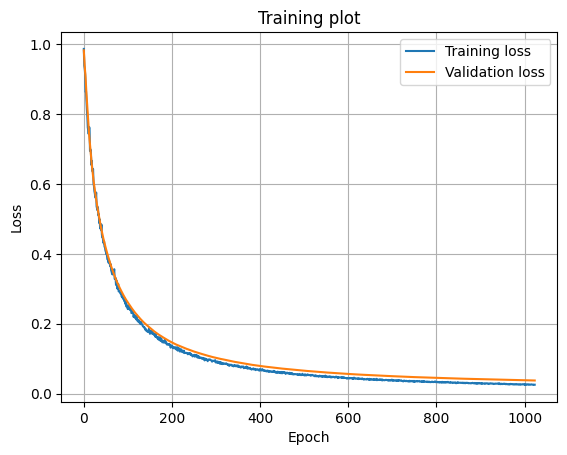

In [20]:
optimiser_rbf = torch.optim.SGD(rbf.parameters(), lr=0.02)
batch_size = 32
epoch_num = 1024

print('Training RBF...')
rbf = train_model_val(rbf, N_training, batch_size, Tdataset, Vdataset, optimiser_rbf, epoch_num)

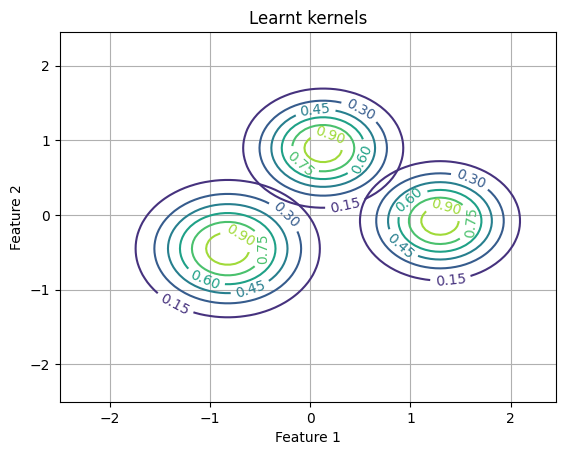

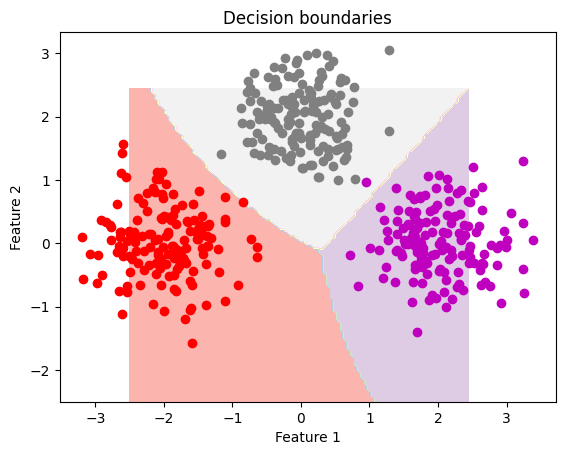

In [39]:
# PLOT KERNELS

kernels = rbf.get_kernels_centers.numpy()
shapes = rbf.get_shapes.numpy()

x = y = np.arange(-2.5, 2.5, 0.05)
X, Y = np.meshgrid(x, y)
fig, ax = plt.subplots()

for i in range(3):
    center = kernels[i][:, None].repeat(10000, axis=1).T
    zs = np.array(fun(X.ravel(), Y.ravel(), center, shapes[i].repeat(10000)))
    Z = zs.reshape(X.shape)

    CS = ax.contour(X, Y, Z)
    ax.clabel(CS, inline=True, fontsize=10)

ax.set_title('Learnt kernels')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.grid()
plt.show()

x = y = np.arange(-2.5, 2.5, 0.05)
X, Y = np.meshgrid(x, y)

# Compute model prediction
inp = torch.tensor(np.array([X.ravel(), Y.ravel()])).T
Z = rbf(inp).argmax(dim=1).detach().numpy()

# Put the result into a color plot
Z = Z.reshape(X.shape)
plt.contourf(X, Y, Z, cmap=cm.Pastel1)

# Plot dataset
plt.scatter(X0[:, 0], X0[:, 1], c='r')
plt.scatter(X1[:, 0], X1[:, 1], c='m')
plt.scatter(X2[:, 0], X2[:, 1], c='gray')

plt.title('Decision boundaries')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.plot()
plt.show()

In [22]:
# We can compare to MLPs

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 3),
            nn.Sigmoid(),
            nn.Linear(3, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

Training Simple NN...
	Epoch 100 acc (training): 47.00%
	Epoch 100 acc (validation): 47.43%
	Epoch 200 acc (training): 100.00%
	Epoch 200 acc (validation): 99.14%
	Epoch 300 acc (training): 100.00%
	Epoch 300 acc (validation): 100.00%
	Epoch 400 acc (training): 100.00%
	Epoch 400 acc (validation): 99.79%
	Epoch 500 acc (training): 100.00%
	Epoch 500 acc (validation): 100.00%
	Epoch 600 acc (training): 100.00%
	Epoch 600 acc (validation): 99.71%
	Epoch 700 acc (training): 100.00%
	Epoch 700 acc (validation): 99.71%
	Epoch 800 acc (training): 100.00%
	Epoch 800 acc (validation): 99.71%
	Epoch 900 acc (training): 100.00%
	Epoch 900 acc (validation): 99.71%
	Epoch 1000 acc (training): 100.00%
	Epoch 1000 acc (validation): 99.71%


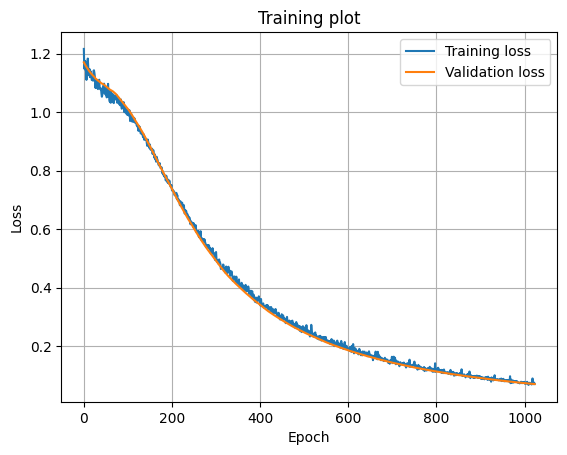

In [23]:
simpleNN = SimpleNN()
optimiser_nn = torch.optim.Adam(simpleNN.parameters(), lr=1e-3)
print('Training Simple NN...')
simpleNN = train_model_val(simpleNN, N_training, batch_size, Tdataset, Vdataset, optimiser_nn, epoch_num)

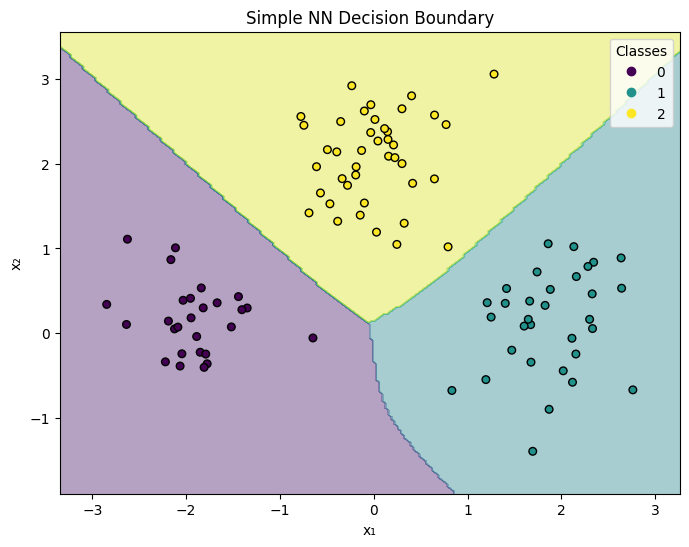

In [38]:
simpleNN.eval()

# Extract points and labels
X = Tdataset[0]
y = Tdataset[1].reshape(-1)

# Move to numpy
X_np = X.numpy()
y_np = y.numpy()

# Create a mesh grid for the background
x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict over the grid
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    Z = simpleNN(grid)
    Z = torch.argmax(Z, dim=1).numpy()

Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.viridis)

# Overlay the data points
scatter = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, s=30, edgecolors='k', cmap=plt.cm.viridis)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("Simple NN Decision Boundary")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.show()

In [36]:
for i, data in enumerate(Tdataset):
    print(i, torch.as_tensor(data).shape)
    if i == 5:
        break

0 torch.Size([100, 2])
1 torch.Size([100, 1])
